# Milestone 2

In [1]:
%cd ..
# imports 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scripts_m2 import *


c:\Users\001\OneDrive\Desktop\GUC\semester 10\nlp\NLP_PROJECT_111


### 1. Exploring the Dataset

In [2]:
# Loading the training data
import json 

with open('data/m2_train.json', 'r') as f:
    squad_data = json.load(f)

print(squad_data['data'][0]['paragraphs'][0].keys())

print(json.dumps(squad_data['data'][0], indent=2))

dict_keys(['qas', 'context'])
{
  "title": "Beyonc\u00e9",
  "paragraphs": [
    {
      "qas": [
        {
          "question": "When did Beyonce start becoming popular?",
          "id": "56be85543aeaaa14008c9063",
          "answers": [
            {
              "text": "in the late 1990s",
              "answer_start": 269
            }
          ],
          "is_impossible": false
        },
        {
          "question": "What areas did Beyonce compete in when she was growing up?",
          "id": "56be85543aeaaa14008c9065",
          "answers": [
            {
              "text": "singing and dancing",
              "answer_start": 207
            }
          ],
          "is_impossible": false
        },
        {
          "question": "When did Beyonce leave Destiny's Child and become a solo singer?",
          "id": "56be85543aeaaa14008c9066",
          "answers": [
            {
              "text": "2003",
              "answer_start": 526
            }
          ],


In [3]:
# Counting the number of answerable and unanswerable questions
num_answerable = 0
num_unanswerable = 0

for article in squad_data["data"]:
    for paragraph in article["paragraphs"]:
        for qa in paragraph["qas"]:
            if qa["is_impossible"]:
                num_unanswerable += 1
            else:
                num_answerable += 1

print("Number of answerable questions: ", num_answerable)
print("Number of unanswerable questions: ", num_unanswerable)
print("Number of QA pairs: ", num_answerable + num_unanswerable)

Number of answerable questions:  86821
Number of unanswerable questions:  43498
Number of QA pairs:  130319


Answerable vs. Unanswerable Questions in SQuAD 2.0

- **Answerable Questions:** The correct answer exists within the given passage, and the model must extract the exact span.
- **Unanswerable Questions:** The passage does not contain the answer, and the model should predict "No Answer."

SQuAD 2.0 introduces unanswerable questions to make the task more challenging, requiring models to distinguish between when an answer is present and when it is not.

In this notebook, we will use answerable questions only in the subset we will be training our neural networks on

### 2. Preprocessing the dataset

In [4]:
# Clean text function
import re

def clean_text(text: str, is_question: bool=False):
    """
    Cleans text by removing extra spaces, newline characters, and special symbols.
    """
    if is_question:
        text = text.replace("\n", " ").replace("\t", " ")  # Remove newlines & tabs
        text = re.sub(r"\s+", " ", text)  # Remove extra spaces
        text = text.strip()  # Trim leading/trailing spaces
    text = text.lower()  # Convert to lowercase
    return text

# Testing the clean_text function on a sample text
sample_text = "   This is a \n\n\t sample    text.    "
print("Original text:", sample_text)
print("Cleaned text:", clean_text(sample_text))

Original text:    This is a 

	 sample    text.    
Cleaned text:    this is a 

	 sample    text.    


In [5]:
# Load and process the SQuAD dataset using the clean_text function
import json

def load_and_process_squad(filepath, max_samples=20000):
    """
    Loads, cleans, and extracts answerable questions from the SQuAD dataset.

    Args:
        filepath (str): Path to the SQuAD JSON file.
        max_samples (int): Maximum number of answerable questions to load.

    Returns:
        List[dict]: A list of cleaned question-answer pairs.
    """
    with open(filepath, "r") as f:
        squad_data = json.load(f)

    data = []
    for article in squad_data["data"]:
        for paragraph in article["paragraphs"]:
            context = clean_text(paragraph["context"]) 
            for qa in paragraph["qas"]:
                if qa["is_impossible"]:  
                    continue
                
                question = clean_text(qa["question"], is_question=True) 
                answer_text = clean_text(qa["answers"][0]["text"])  
                answer_start = qa["answers"][0]["answer_start"]
                
                data.append({
                    "context": context, 
                    "question": question, 
                    "answer": answer_text, 
                    "answer_start": answer_start, 
                    "answer_end": answer_start + len(answer_text)})


    data.sort(key=lambda x: (len(x["context"]), len(x["question"])))
    # Limit the number of samples if specified
    if max_samples > 0:
        data = data[:max_samples]
    return data

# Load and process the SQuAD dataset
train_dataset = load_and_process_squad("data/m2_train.json", max_samples=-1)
dev_samples = load_and_process_squad("data/m2_dev.json", max_samples=2000)

print("Number of QA pairs in train data:", len(train_dataset))
print("Training sample:", train_dataset[0].keys())
print("\n")
print("Number of QA pairs in test data:", len(dev_samples))
print("Dev sample:", dev_samples[0].keys())


Number of QA pairs in train data: 86821
Training sample: dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])


Number of QA pairs in test data: 2000
Dev sample: dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])


### 3. Tokenization

In [6]:
unique_words = set()

for sample in train_dataset:
    context = sample["context"]
    question = sample["question"]
    answer = sample["answer"]

    unique_words.update(set(re.findall(r"\w+", context)))
    unique_words.update(set(re.findall(r"\w+", question)))
    unique_words.update(set(re.findall(r"\w+", answer)))

                
# Print the number of unique words
print("Number of unique words in the training set:", len(unique_words))

Number of unique words in the training set: 82597


In [7]:
combined_text = []
for sample in train_dataset:
    combined_text.append(sample["context"])
    combined_text.append(sample["question"])
    combined_text.append(sample["answer"])

# Join all text samples into one corpus (you can also use '\n'.join for a more distinct separation)
combined_text = "\n".join(combined_text)


In [8]:
# Training the tokenizer
from scripts_m2 import *

# Creating / Loading the tokenizer
tokenizer = BPETokenizer()

# Training the tokenizer if not already trained
tokenizer.train(combined_text=combined_text.split("/n"), vocab_size=10000)


Loading tokenizer from ./tokenizers/tokenizer.json...
Tokenizer already exists at ./tokenizers/tokenizer.json. Skipping training.


In [9]:
# Encoding a Question
example_question = train_dataset[4]["question"]
tokenized_output, attention_mask = tokenizer.encode(example_question)
print("Tokenized Question:", tokenized_output)
print("Length of Tokenized Question:", len(tokenized_output))
print("Attention Mask:", attention_mask)

# Decoding the tokenized output
decoded_output = tokenizer.decode(tokenized_output)
print("Decoded Question:", decoded_output)

Tokenized Question: [3, 2441, 1997, 1966, 4721, 2776, 1974, 3539, 1978, 7873, 3120, 1390, 4]
Length of Tokenized Question: 13
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Decoded Question: where is the oklahoma school of science and mathematics located ?


In [10]:
# Changing the max tokenizer length
tokenizer.set_max_length(25)

In [11]:
# Encoding an answer
example_answer = train_dataset[4]["answer"]
tokenized_answer, attention_mask = tokenizer.encode(example_answer)
print("Tokenized Answer:", tokenized_answer)
print("Length of Tokenized Answer:", len(tokenized_answer))
print("Attention Mask:", attention_mask)

# Decoding the tokenized answer
decoded_answer = tokenizer.decode(tokenized_answer)
print("Decoded Answer:", decoded_answer)

Tokenized Answer: [3, 4721, 2251, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Length of Tokenized Answer: 25
Attention Mask: [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded Answer: oklahoma city


### 4. Dataset & Data Loaders

In [12]:
# Getting the dataset
train_dataset = load_and_process_squad("data/m2_train.json", max_samples=20000)
dev_dataset = load_and_process_squad("data/m2_dev.json", max_samples=2000)
print("Number of training samples:", len(train_dataset))
print("Number of dev samples:", len(dev_dataset))

Number of training samples: 20000
Number of dev samples: 2000


In [13]:
# Create the tokenizer
tokenizer = BPETokenizer()
# Train the tokenizer
tokenizer.train(combined_text=combined_text.split("\n"), vocab_size=10000)

Loading tokenizer from ./tokenizers/tokenizer.json...
Tokenizer already exists at ./tokenizers/tokenizer.json. Skipping training.


In [14]:
# View the training data
random_idx = np.random.randint(0, len(train_dataset))

# Print the random sample
print(train_dataset[random_idx].keys())
print("Training data sample:")
print(train_dataset[random_idx]["context"])
print(train_dataset[random_idx]["question"])
print(train_dataset[random_idx]["answer"])
print("Answer start:", train_dataset[random_idx]["answer_start"])
print("Answer end:", train_dataset[random_idx]["answer_end"])
print("Length of the training examples:", len(train_dataset))

dict_keys(['context', 'question', 'answer', 'answer_start', 'answer_end'])
Training data sample:
according to east asian and tibetan buddhism, there is an intermediate state (tibetan "bardo") between one life and the next. the orthodox theravada position rejects this; however there are passages in the samyutta nikaya of the pali canon that seem to lend support to the idea that the buddha taught of an intermediate stage between one life and the next.[page needed]
there is a transitional state between one life and the next according to what branches of buddhism?
east asian and tibetan
Answer start: 13
Answer end: 35
Length of the training examples: 20000


In [15]:
q = tokenizer.encode(train_dataset[4]["question"])[0]
tokenizer.decode(q)

'where is the oklahoma school of science and mathematics located ?'

In [16]:
# Viewing the length of the longest question, context, and answer
max_context_length = max(len(tokenizer.encode(sample["context"])[0]) for sample in train_dataset)
max_question_length = max(len(tokenizer.encode(sample["question"])[0]) for sample in train_dataset)
max_answer_length = max(len(tokenizer.encode(sample["answer"])[0]) for sample in train_dataset)

print("Max context length:", max_context_length)
print("Max question length:", max_question_length)
print("Max answer length:", max_answer_length)

Max context length: 205
Max question length: 64
Max answer length: 75


Summary Statistics for Context Lengths:
Number of questions: 20000
Number of outliers: 18
Minimum: 29
Q1 (25%): 83.0
Median: 110.0
Q3 (75%): 124.0
Maximum: 205
Interquartile Range (IQR): 41.0
95th Percentile: 143.0
97th Percentile: 149.0
99th Percentile: 160.0


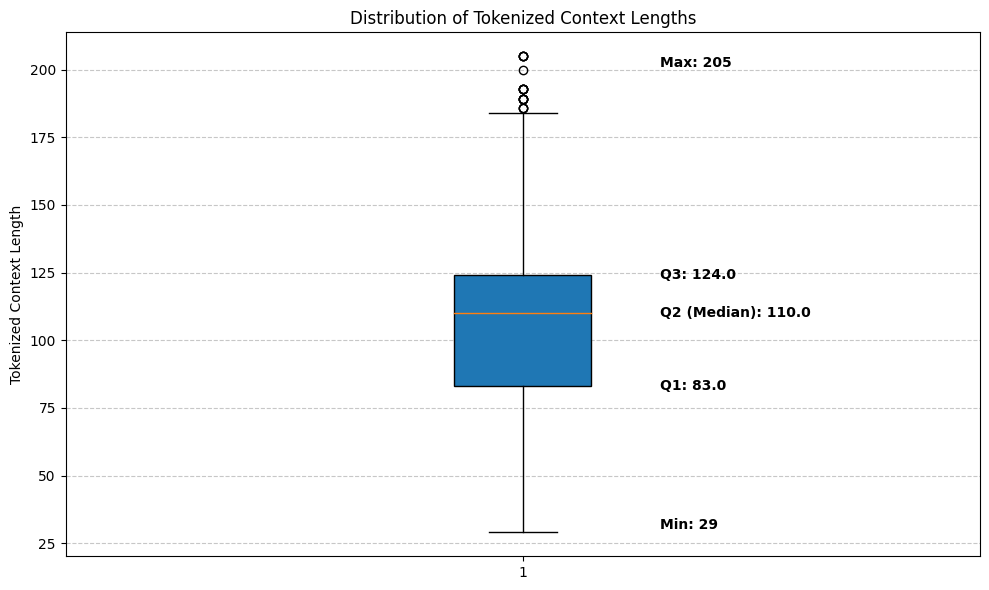

In [17]:
# Visualizing the distribution of tokenized question lengths
context_lengths = [len(tokenizer.encode(sample["context"])[0]) for sample in train_dataset]
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(context_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Context Lengths")
plt.ylabel("Tokenized Context Length")

# Calculate and display quartiles
quartiles = np.percentile(context_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(context_lengths)
max_val = np.max(context_lengths)

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}', 
         verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}', 
         verticalalignment='top', fontweight='bold')

print(f"Summary Statistics for Context Lengths:")
print("Number of questions:", len(context_lengths))
print("Number of outliers:", len([x for x in context_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in context_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Summary Statistics for Question Lengths:
Number of questions: 20000
Number of outliers: 407
Minimum: 6
Q1 (25%): 12.0
Median: 15.0
Q3 (75%): 18.0
Maximum: 64
Interquartile Range (IQR): 6.0
95th Percentile: 24.0
97th Percentile: 26.0
99th Percentile: 30.0


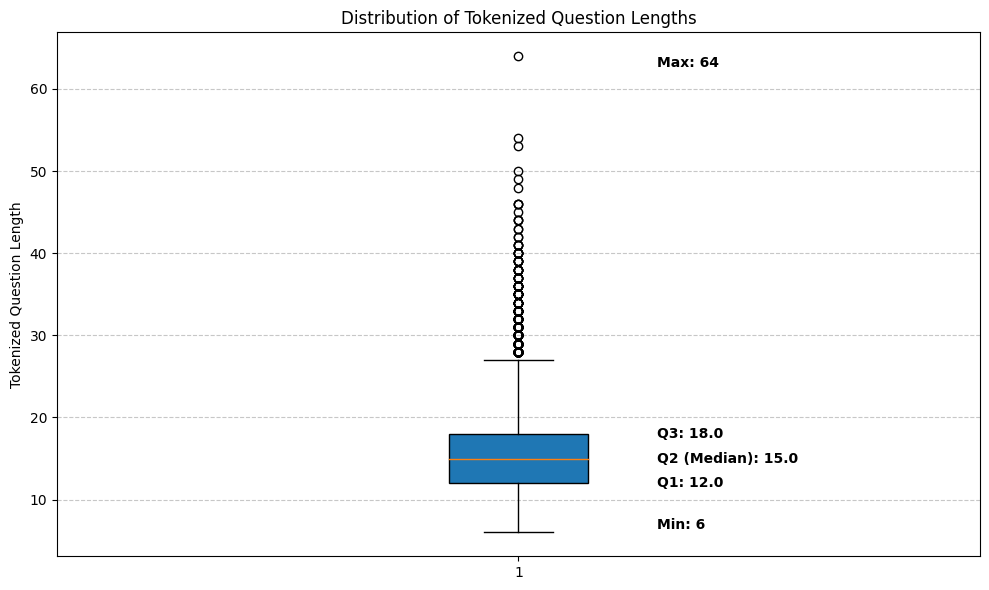

In [18]:
# Visualizing the distribution of tokenized question lengths
question_lengths = [len(tokenizer.encode(sample["question"])[0]) for sample in train_dataset]
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(question_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Question Lengths")
plt.ylabel("Tokenized Question Length")

# Calculate and display quartiles
quartiles = np.percentile(question_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(question_lengths)
max_val = np.max(question_lengths)

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}', 
         verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}', 
         verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}', 
         verticalalignment='top', fontweight='bold')

print(f"Summary Statistics for Question Lengths:")
print("Number of questions:", len(question_lengths))
print("Number of outliers:", len([x for x in question_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in question_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Summary Statistics for Answer Lengths:
Number of answers:  20000
Number of outliers:  1705
Minimum: 3
Q1 (25%): 4.0
Median: 5.0
Q3 (75%): 7.0
Maximum: 75
Interquartile Range (IQR): 3.0
95th Percentile: 14.0
97th Percentile: 18.0
99th Percentile: 25.0


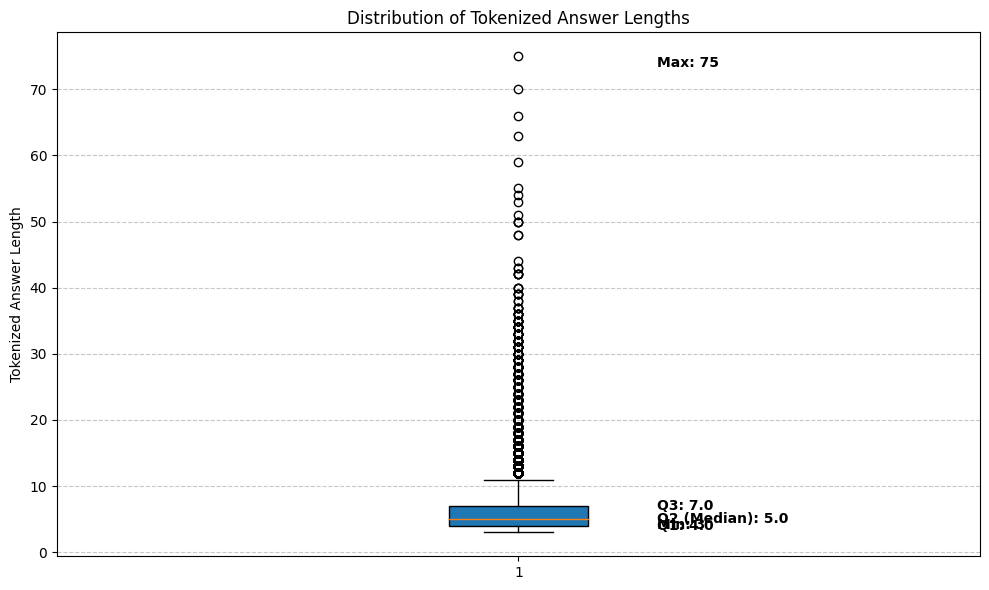

In [19]:
# Visualizing the distribution of tokenized answer lengths
answer_lengths = [len(tokenizer.encode(sample["answer"])[0]) for sample in train_dataset]

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(answer_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Answer Lengths")
plt.ylabel("Tokenized Answer Length")
# Calculate and display quartiles
quartiles = np.percentile(answer_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(answer_lengths)
max_val = np.max(answer_lengths)

print(f"Summary Statistics for Answer Lengths:")
print("Number of answers: ", len(answer_lengths))
print("Number of outliers: ", len([x for x in answer_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in answer_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}',
            verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}',
            verticalalignment='top', fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Summary Statistics for context + question Lengths:
Number of context + question:  20000
Number of outliers:  10
Minimum: 39
Q1 (25%): 97.0
Median: 124.0
Q3 (75%): 139.0
Maximum: 224
Interquartile Range (IQR): 42.0
95th Percentile: 159.0
97th Percentile: 164.0
99th Percentile: 175.0


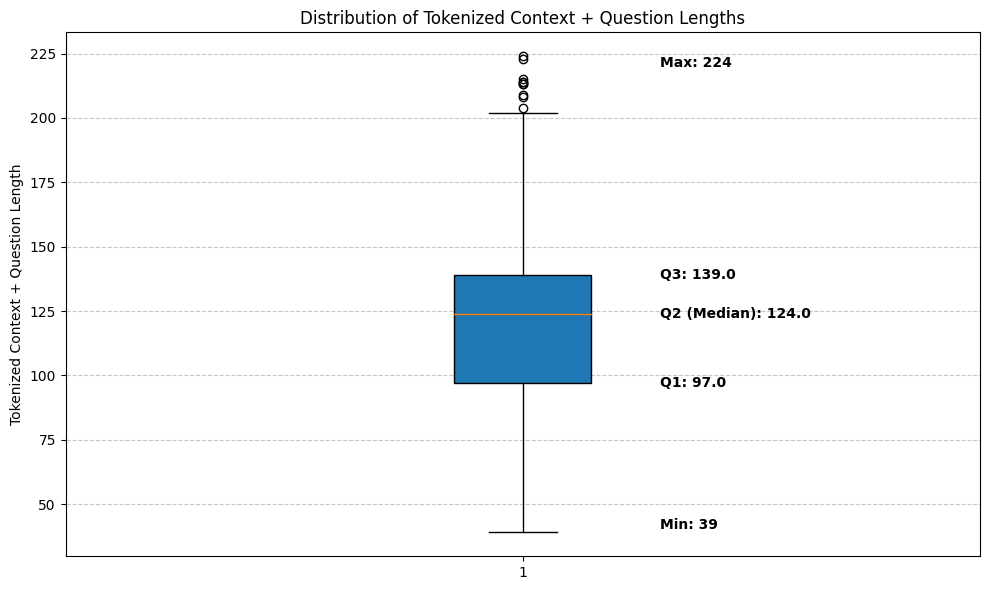

In [20]:
# Visualizing the distribution of tokenized answer lengths
context_question_lengths = [len(tokenizer.encode_two_texts(sample["context"], sample["question"])[0]) for sample in train_dataset]

plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(context_question_lengths, vert=True, patch_artist=True)
plt.title("Distribution of Tokenized Context + Question Lengths")
plt.ylabel("Tokenized Context + Question Length")
# Calculate and display quartiles
quartiles = np.percentile(context_question_lengths, [25, 50, 75, 95, 97, 99])
min_val = np.min(context_question_lengths)
max_val = np.max(context_question_lengths)

print(f"Summary Statistics for context + question Lengths:")
print("Number of context + question: ", len(context_question_lengths))
print("Number of outliers: ", len([x for x in context_question_lengths if x > quartiles[2] + 1.5 * (quartiles[2] - quartiles[0])]) + len([x for x in context_question_lengths if x < quartiles[0] - 1.5 * (quartiles[2] - quartiles[0])]))
print(f"Minimum: {min_val}")
print(f"Q1 (25%): {quartiles[0]:.1f}")
print(f"Median: {quartiles[1]:.1f}")
print(f"Q3 (75%): {quartiles[2]:.1f}")
print(f"Maximum: {max_val}")
print(f"Interquartile Range (IQR): {quartiles[2] - quartiles[0]:.1f}")
print("95th Percentile:", quartiles[3])
print("97th Percentile:", quartiles[4])
print("99th Percentile:", quartiles[5])

plt.text(1.15, quartiles[0], f'Q1: {quartiles[0]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[1], f'Q2 (Median): {quartiles[1]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, quartiles[2], f'Q3: {quartiles[2]:.1f}',
            verticalalignment='center', fontweight='bold')
plt.text(1.15, min_val, f'Min: {min_val}',
            verticalalignment='bottom', fontweight='bold')
plt.text(1.15, max_val, f'Max: {max_val}',
            verticalalignment='top', fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

So for the transformer based models we can use the max length of the question and answer as follows:
1. `Answers Max Length`: 25 tokens
2. `Question Max Length`: 30 tokens
3. `Context Max Length`: 160 tokens
4. `Context + Question Length`: 160+30+1 (+1 for [SEP]) We could have used 175 as it is the 99th percentile but we will use 191 instead


This would give us a good tradeoff between the length of the sequence without using a lot of padding.

In [21]:
# Creating dataset
tokenizer = BPETokenizer()
train_data = load_and_process_squad("data/m2_train.json", max_samples=20000)
dev_data = load_and_process_squad("data/m2_dev.json", max_samples=2000)

context_max_length = 160
question_max_length = 30
answer_max_length = 25
train_dataset = QADataset(train_data, tokenizer, context_max_length=context_max_length, question_max_length=question_max_length, answer_max_length=answer_max_length, include_context=True)
dev_dataset = QADataset(dev_data, tokenizer, context_max_length=context_max_length, question_max_length=question_max_length, answer_max_length=answer_max_length, include_context=True)
print("Number of training samples:", len(train_dataset))
print("Number of dev samples:", len(dev_dataset))

# View a sample from the dataset
random_idx = np.random.randint(0, len(train_dataset))
print("Sample from the dataset:")
print("Question encoded:", train_dataset[random_idx]["question"])
print("Question decoded: ", tokenizer.decode(train_dataset[random_idx]["question"].tolist()))
print("Answer encoded:", train_dataset[random_idx]["answer"])
print("Answer decoded: ", tokenizer.decode(train_dataset[random_idx]["answer"].tolist()))
print("Context encoded:", train_dataset[random_idx]["context"])
print("Context decoded: ", tokenizer.decode(train_dataset[random_idx]["context"].tolist()))
print("\n\n")

# View a sample from the dev dataset
random_idx = np.random.randint(0, len(dev_dataset))
print("Sample from the dev dataset:")
print("Context encoded:", dev_dataset[random_idx]["context"])
print("Context decoded: ", tokenizer.decode(dev_dataset[random_idx]["context"].tolist()))
print("Question encoded:", dev_dataset[random_idx]["question"])
print("Question decoded: ", tokenizer.decode(dev_dataset[random_idx]["question"].tolist()))
print("Answer encoded:", dev_dataset[random_idx]["answer"])
print("Answer decoded: ", tokenizer.decode(dev_dataset[random_idx]["answer"].tolist()))
print("Context Question encoded:", dev_dataset[random_idx]["context_question"])
print("Context Question decoded: ", tokenizer.decode(dev_dataset[random_idx]["context_question"].tolist()))
print("Answer Start:", dev_dataset[random_idx]["answer_start"])
print("Answer End:", dev_dataset[random_idx]["answer_end"])
print("Answer Start: End decoded:", tokenizer.decode(dev_dataset[random_idx]["context"][dev_dataset[random_idx]["answer_start"]:dev_dataset[random_idx]["answer_end"]+1].tolist()))


Loading tokenizer from ./tokenizers/tokenizer.json...
Filtered dataset size: 19993 out of original 20000
Filtered dataset size: 1996 out of original 2000
Number of training samples: 19993
Number of dev samples: 1996
Sample from the dataset:
Question encoded: tensor([   3, 2276, 2268, 2387, 2016, 6579, 1966, 7170, 1359, 8611, 1390,    4,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1])
Question decoded:  when did ellen join the judges ' panel ?
Answer encoded: tensor([   3, 9604, 5294,    4,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1])
Answer decoded:  hollywood week
Context encoded: tensor([   3, 3050, 5158, 4266, 2702, 1980, 3442, 3101, 1283, 3232, 1321, 1966,
          63, 2147,   47, 2218, 1993, 1996, 1966, 3304, 7103, 8611, 3402, 1321,
        2387, 2016, 2028, 2422, 1986, 5361, 1990, 1267, 7870, 1989, 8619, 31

In [22]:
# Creating Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) # add this `num_workers=0` if you want to see print in __getitem__ in dataset class
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

for batch in train_dataloader:
    print(batch.keys())
    print(batch['context_question'].shape)
    print(batch['question'].shape)
    print(batch['answer'].shape)
    print(batch['attention_mask_question'].shape)
    print(batch['attention_mask_answer'].shape)
    print(batch['attention_mask_context_question'].shape)
    print(batch['answer_start'], batch['answer_end'])
    print("-" * 50)

dict_keys(['question', 'attention_mask_question', 'answer', 'attention_mask_answer', 'context', 'attention_mask_context', 'context_question', 'attention_mask_context_question', 'answer_start', 'answer_end'])
torch.Size([32, 191])
torch.Size([32, 30])
torch.Size([32, 25])
torch.Size([32, 30])
torch.Size([32, 25])
torch.Size([32, 191])
tensor([116,   4,  89,  63,  63,   3,  13,  64,  73,  67, 106,  25,  41,  25,
         62,  52,  14,   2, 132,  89,  51,  66,  37, 105, 130,  10,   0,  22,
         52, 116,  40,  51]) tensor([117,   5,  93,  65,  67,   4,  15,  65,  75,  67, 108,  26,  43,  26,
         64,  55,  18,   2, 133,  91,  53,  75,  38, 108, 131,  12,   1,  25,
         56, 117,  41,  51])
--------------------------------------------------
dict_keys(['question', 'attention_mask_question', 'answer', 'attention_mask_answer', 'context', 'attention_mask_context', 'context_question', 'attention_mask_context_question', 'answer_start', 'answer_end'])
torch.Size([32, 191])
torch.Size([3

### 5. Phase 1: Model Training

In [23]:
vocab_size = 10000

# Initialize the model
model = RNN_QA_Model(
    vocab_size=vocab_size,
    embedding_dim=256,
    hidden_dim=256,
    num_layers=3,
    dropout=0.5,
    pad_idx=1
)

#  loss function
criterion = nn.CrossEntropyLoss()
#  optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
# Training the model
train_qa_context_model(
    model=model, 
    train_dataloader=train_dataloader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=50,
    device='cuda', 
    val_dataloader=dev_dataloader, 
    evaluate_val_dataset=True
)

Epoch 1/50: 100%|██████████| 625/625 [00:13<00:00, 46.76it/s, loss=6.52]


Epoch 1 Loss: 7.7158


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 60.86it/s]


Validation Loss: 7.6206
Validation Metrics: {'start_accuracy': 0.08216432865731463, 'start_precision': 0.08784456494918455, 'start_recall': 0.08216432865731463, 'start_f1_score': 0.07825977613824404, 'end_accuracy': 0.09168336673346693, 'end_precision': 0.09137172274059968, 'end_recall': 0.09168336673346693, 'end_f1_score': 0.08528390412564232, 'joint_exact_match': 0.024549098196392786, 'span_overlap_f1': 0.06088804753580131}


Epoch 2/50: 100%|██████████| 625/625 [00:13<00:00, 46.46it/s, loss=6.8] 


Epoch 2 Loss: 7.1858


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 60.48it/s]


Validation Loss: 7.7867
Validation Metrics: {'start_accuracy': 0.0811623246492986, 'start_precision': 0.08365035911246604, 'start_recall': 0.0811623246492986, 'start_f1_score': 0.07581565350198566, 'end_accuracy': 0.08366733466933868, 'end_precision': 0.07222468673574467, 'end_recall': 0.08366733466933868, 'end_f1_score': 0.0707134317967252, 'joint_exact_match': 0.02004008016032064, 'span_overlap_f1': 0.05533935375528682}


Epoch 3/50: 100%|██████████| 625/625 [00:13<00:00, 46.37it/s, loss=7.42]


Epoch 3 Loss: 6.7167


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.49it/s]


Validation Loss: 7.5606
Validation Metrics: {'start_accuracy': 0.08767535070140281, 'start_precision': 0.0842003923703452, 'start_recall': 0.08767535070140281, 'start_f1_score': 0.07943862907756531, 'end_accuracy': 0.09018036072144289, 'end_precision': 0.0894025599067649, 'end_recall': 0.09018036072144289, 'end_f1_score': 0.07950637694362112, 'joint_exact_match': 0.03206412825651302, 'span_overlap_f1': 0.06359990012204257}


Epoch 4/50: 100%|██████████| 625/625 [00:13<00:00, 46.29it/s, loss=7.62]


Epoch 4 Loss: 6.2998


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 56.59it/s]


Validation Loss: 7.6494
Validation Metrics: {'start_accuracy': 0.09719438877755511, 'start_precision': 0.0893825063332601, 'start_recall': 0.09719438877755511, 'start_f1_score': 0.08514701347261106, 'end_accuracy': 0.0966933867735471, 'end_precision': 0.08611839361647919, 'end_recall': 0.0966933867735471, 'end_f1_score': 0.08489628359608191, 'joint_exact_match': 0.036072144288577156, 'span_overlap_f1': 0.07092690680662828}


Epoch 5/50: 100%|██████████| 625/625 [00:13<00:00, 46.36it/s, loss=6.39]


Epoch 5 Loss: 5.9899


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 60.89it/s]


Validation Loss: 7.7686
Validation Metrics: {'start_accuracy': 0.09819639278557114, 'start_precision': 0.09674655679549422, 'start_recall': 0.09819639278557114, 'start_f1_score': 0.09183084772598536, 'end_accuracy': 0.09719438877755511, 'end_precision': 0.08496588194560256, 'end_recall': 0.09719438877755511, 'end_f1_score': 0.08509197705714876, 'joint_exact_match': 0.04408817635270541, 'span_overlap_f1': 0.07836650157844181}


Epoch 6/50: 100%|██████████| 625/625 [00:13<00:00, 46.92it/s, loss=5.69]


Epoch 6 Loss: 5.7068


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 59.57it/s]


Validation Loss: 8.0832
Validation Metrics: {'start_accuracy': 0.09468937875751503, 'start_precision': 0.09267473128745354, 'start_recall': 0.09468937875751503, 'start_f1_score': 0.0869932121381396, 'end_accuracy': 0.09919839679358718, 'end_precision': 0.09289729538725193, 'end_recall': 0.09919839679358718, 'end_f1_score': 0.08917738664111341, 'joint_exact_match': 0.03707414829659319, 'span_overlap_f1': 0.07323537262496906}


Epoch 7/50: 100%|██████████| 625/625 [00:13<00:00, 47.70it/s, loss=5.75]


Epoch 7 Loss: 5.4105


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.21it/s]


Validation Loss: 8.2478
Validation Metrics: {'start_accuracy': 0.093687374749499, 'start_precision': 0.08801059753495605, 'start_recall': 0.093687374749499, 'start_f1_score': 0.08483037463447647, 'end_accuracy': 0.09118236472945891, 'end_precision': 0.0846650146818527, 'end_recall': 0.09118236472945891, 'end_f1_score': 0.0810033096771122, 'joint_exact_match': 0.04308617234468938, 'span_overlap_f1': 0.07565305001161385}


Epoch 8/50: 100%|██████████| 625/625 [00:13<00:00, 48.03it/s, loss=5]   


Epoch 8 Loss: 5.0846


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 64.34it/s]


Validation Loss: 8.8936
Validation Metrics: {'start_accuracy': 0.08066132264529058, 'start_precision': 0.0735532333715045, 'start_recall': 0.08066132264529058, 'start_f1_score': 0.0669081085468651, 'end_accuracy': 0.08767535070140281, 'end_precision': 0.08614645797846895, 'end_recall': 0.08767535070140281, 'end_f1_score': 0.07780256591644372, 'joint_exact_match': 0.03256513026052104, 'span_overlap_f1': 0.06808839233797154}


Epoch 9/50: 100%|██████████| 625/625 [00:12<00:00, 48.23it/s, loss=4.93]


Epoch 9 Loss: 4.8059


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 62.72it/s]


Validation Loss: 9.1814
Validation Metrics: {'start_accuracy': 0.09118236472945891, 'start_precision': 0.08333511834999413, 'start_recall': 0.09118236472945891, 'start_f1_score': 0.07918260031008897, 'end_accuracy': 0.08016032064128256, 'end_precision': 0.07809112134905873, 'end_recall': 0.08016032064128256, 'end_f1_score': 0.07193130621200164, 'joint_exact_match': 0.033066132264529056, 'span_overlap_f1': 0.0665695581918706}


Epoch 10/50: 100%|██████████| 625/625 [00:13<00:00, 47.39it/s, loss=5.22]


Epoch 10 Loss: 4.5488


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.44it/s]


Validation Loss: 9.6084
Validation Metrics: {'start_accuracy': 0.08216432865731463, 'start_precision': 0.07839394240354328, 'start_recall': 0.08216432865731463, 'start_f1_score': 0.07286083962367021, 'end_accuracy': 0.08667334669338678, 'end_precision': 0.08291753729292645, 'end_recall': 0.08667334669338678, 'end_f1_score': 0.07806535220639751, 'joint_exact_match': 0.028056112224448898, 'span_overlap_f1': 0.06438999009942044}


Epoch 11/50: 100%|██████████| 625/625 [00:12<00:00, 48.46it/s, loss=4.16]


Epoch 11 Loss: 4.3202


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.09it/s]


Validation Loss: 10.3559
Validation Metrics: {'start_accuracy': 0.07965931863727455, 'start_precision': 0.07438974329348991, 'start_recall': 0.07965931863727455, 'start_f1_score': 0.07181477280192786, 'end_accuracy': 0.08216432865731463, 'end_precision': 0.07719468525728934, 'end_recall': 0.08216432865731463, 'end_f1_score': 0.07519147145959618, 'joint_exact_match': 0.02655310621242485, 'span_overlap_f1': 0.05783906665848703}


Epoch 12/50: 100%|██████████| 625/625 [00:13<00:00, 47.62it/s, loss=4.34]


Epoch 12 Loss: 4.1442


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.33it/s]


Validation Loss: 10.5947
Validation Metrics: {'start_accuracy': 0.08567134268537074, 'start_precision': 0.07822457758004048, 'start_recall': 0.08567134268537074, 'start_f1_score': 0.07373314023288104, 'end_accuracy': 0.08066132264529058, 'end_precision': 0.07769021435657271, 'end_recall': 0.08066132264529058, 'end_f1_score': 0.07178729629862987, 'joint_exact_match': 0.02655310621242485, 'span_overlap_f1': 0.06159627745128422}


Epoch 13/50: 100%|██████████| 625/625 [00:13<00:00, 47.90it/s, loss=3.82]


Epoch 13 Loss: 3.9863


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 59.54it/s]


Validation Loss: 10.4436
Validation Metrics: {'start_accuracy': 0.0746492985971944, 'start_precision': 0.06362230341406114, 'start_recall': 0.0746492985971944, 'start_f1_score': 0.06206356393511729, 'end_accuracy': 0.06162324649298597, 'end_precision': 0.06274869953913009, 'end_recall': 0.06162324649298597, 'end_f1_score': 0.05693064539908484, 'joint_exact_match': 0.016533066132264528, 'span_overlap_f1': 0.058353076890988814}


Epoch 14/50: 100%|██████████| 625/625 [00:13<00:00, 47.92it/s, loss=4.21]


Epoch 14 Loss: 3.8534


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.75it/s]


Validation Loss: 11.7263
Validation Metrics: {'start_accuracy': 0.061122244488977955, 'start_precision': 0.05185911867564638, 'start_recall': 0.061122244488977955, 'start_f1_score': 0.05264575844624525, 'end_accuracy': 0.07515030060120241, 'end_precision': 0.07329259257570069, 'end_recall': 0.07515030060120241, 'end_f1_score': 0.0692851300208513, 'joint_exact_match': 0.01753507014028056, 'span_overlap_f1': 0.06021468129859597}


Epoch 15/50: 100%|██████████| 625/625 [00:13<00:00, 47.58it/s, loss=3.85]


Epoch 15 Loss: 3.7174


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 65.37it/s]


Validation Loss: 11.7528
Validation Metrics: {'start_accuracy': 0.06513026052104208, 'start_precision': 0.058785100192159746, 'start_recall': 0.06513026052104208, 'start_f1_score': 0.055223657735248774, 'end_accuracy': 0.07064128256513026, 'end_precision': 0.07199723737072745, 'end_recall': 0.07064128256513026, 'end_f1_score': 0.06544998422438242, 'joint_exact_match': 0.021042084168336674, 'span_overlap_f1': 0.06096496737716035}


Epoch 16/50: 100%|██████████| 625/625 [00:13<00:00, 48.06it/s, loss=3.54]


Epoch 16 Loss: 3.6458


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.66it/s]


Validation Loss: 11.4283
Validation Metrics: {'start_accuracy': 0.06212424849699399, 'start_precision': 0.060934177858856194, 'start_recall': 0.06212424849699399, 'start_f1_score': 0.05808567282722514, 'end_accuracy': 0.0746492985971944, 'end_precision': 0.08803448411962826, 'end_recall': 0.0746492985971944, 'end_f1_score': 0.07094066245852722, 'joint_exact_match': 0.02404809619238477, 'span_overlap_f1': 0.06354540782512336}


Epoch 17/50: 100%|██████████| 625/625 [00:12<00:00, 48.86it/s, loss=3.67]


Epoch 17 Loss: 3.5406


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 64.66it/s]


Validation Loss: 12.0771
Validation Metrics: {'start_accuracy': 0.07064128256513026, 'start_precision': 0.07327850950890649, 'start_recall': 0.07064128256513026, 'start_f1_score': 0.06595566498189397, 'end_accuracy': 0.0811623246492986, 'end_precision': 0.0921144996205529, 'end_recall': 0.0811623246492986, 'end_f1_score': 0.07858615372186263, 'joint_exact_match': 0.02655310621242485, 'span_overlap_f1': 0.06761679941032658}


Epoch 18/50: 100%|██████████| 625/625 [00:13<00:00, 47.45it/s, loss=3.43]


Epoch 18 Loss: 3.4674


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 56.78it/s]


Validation Loss: 12.4993
Validation Metrics: {'start_accuracy': 0.08166332665330661, 'start_precision': 0.08281911123190895, 'start_recall': 0.08166332665330661, 'start_f1_score': 0.07515140508376308, 'end_accuracy': 0.08567134268537074, 'end_precision': 0.09806087142538261, 'end_recall': 0.08567134268537074, 'end_f1_score': 0.08175806645983157, 'joint_exact_match': 0.03256513026052104, 'span_overlap_f1': 0.07318026551390634}


Epoch 19/50: 100%|██████████| 625/625 [00:13<00:00, 47.84it/s, loss=3.27]


Epoch 19 Loss: 3.3603


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 59.48it/s]


Validation Loss: 12.1746
Validation Metrics: {'start_accuracy': 0.0781563126252505, 'start_precision': 0.09303575294556324, 'start_recall': 0.0781563126252505, 'start_f1_score': 0.07807592294708345, 'end_accuracy': 0.0906813627254509, 'end_precision': 0.10883784237706651, 'end_recall': 0.0906813627254509, 'end_f1_score': 0.08994133679414142, 'joint_exact_match': 0.039579158316633264, 'span_overlap_f1': 0.08259626422946569}


Epoch 20/50: 100%|██████████| 625/625 [00:13<00:00, 47.00it/s, loss=3.27]


Epoch 20 Loss: 3.2150


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 57.95it/s]


Validation Loss: 12.6089
Validation Metrics: {'start_accuracy': 0.0746492985971944, 'start_precision': 0.0911131577297584, 'start_recall': 0.0746492985971944, 'start_f1_score': 0.07390145440985474, 'end_accuracy': 0.08667334669338678, 'end_precision': 0.09749504430827519, 'end_recall': 0.08667334669338678, 'end_f1_score': 0.08441131854125897, 'joint_exact_match': 0.039579158316633264, 'span_overlap_f1': 0.08341328323366551}


Epoch 21/50: 100%|██████████| 625/625 [00:13<00:00, 47.96it/s, loss=3.1] 


Epoch 21 Loss: 3.1002


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 57.92it/s]


Validation Loss: 12.5164
Validation Metrics: {'start_accuracy': 0.08867735470941884, 'start_precision': 0.10457060234597283, 'start_recall': 0.08867735470941884, 'start_f1_score': 0.086486053887253, 'end_accuracy': 0.09819639278557114, 'end_precision': 0.12224209982795482, 'end_recall': 0.09819639278557114, 'end_f1_score': 0.10040776052576253, 'joint_exact_match': 0.04959919839679359, 'span_overlap_f1': 0.09702928727783038}


Epoch 22/50: 100%|██████████| 625/625 [00:13<00:00, 47.07it/s, loss=3.08]


Epoch 22 Loss: 2.9945


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.09it/s]


Validation Loss: 12.4039
Validation Metrics: {'start_accuracy': 0.08767535070140281, 'start_precision': 0.12119900465225472, 'start_recall': 0.08767535070140281, 'start_f1_score': 0.08768204533245406, 'end_accuracy': 0.10170340681362726, 'end_precision': 0.14968532873920942, 'end_recall': 0.10170340681362726, 'end_f1_score': 0.10185281102602907, 'joint_exact_match': 0.050100200400801605, 'span_overlap_f1': 0.09462225333877049}


Epoch 23/50: 100%|██████████| 625/625 [00:13<00:00, 47.49it/s, loss=3.74]


Epoch 23 Loss: 2.8764


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.28it/s]


Validation Loss: 12.7879
Validation Metrics: {'start_accuracy': 0.10220440881763528, 'start_precision': 0.11116307922552951, 'start_recall': 0.10220440881763528, 'start_f1_score': 0.0989941995862921, 'end_accuracy': 0.11372745490981964, 'end_precision': 0.1362789983596334, 'end_recall': 0.11372745490981964, 'end_f1_score': 0.1140797444899898, 'joint_exact_match': 0.05811623246492986, 'span_overlap_f1': 0.11088058672509336}


Epoch 24/50: 100%|██████████| 625/625 [00:13<00:00, 47.49it/s, loss=2.66]


Epoch 24 Loss: 2.7620


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 59.51it/s]


Validation Loss: 12.9313
Validation Metrics: {'start_accuracy': 0.09919839679358718, 'start_precision': 0.10672952111012324, 'start_recall': 0.09919839679358718, 'start_f1_score': 0.09563248779921944, 'end_accuracy': 0.10220440881763528, 'end_precision': 0.12605064768294857, 'end_recall': 0.10220440881763528, 'end_f1_score': 0.10481617119124864, 'joint_exact_match': 0.050100200400801605, 'span_overlap_f1': 0.09980016763195904}


Epoch 25/50: 100%|██████████| 625/625 [00:13<00:00, 47.39it/s, loss=2.61]


Epoch 25 Loss: 2.6595


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 60.52it/s]


Validation Loss: 12.9455
Validation Metrics: {'start_accuracy': 0.09519038076152304, 'start_precision': 0.1152542464572385, 'start_recall': 0.09519038076152304, 'start_f1_score': 0.09483356292880604, 'end_accuracy': 0.10671342685370741, 'end_precision': 0.13017063693728623, 'end_recall': 0.10671342685370741, 'end_f1_score': 0.10782493655695385, 'joint_exact_match': 0.05511022044088176, 'span_overlap_f1': 0.10476735129196524}


Epoch 26/50: 100%|██████████| 625/625 [00:13<00:00, 47.57it/s, loss=2.76]


Epoch 26 Loss: 2.5642


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 58.18it/s]


Validation Loss: 13.4022
Validation Metrics: {'start_accuracy': 0.09519038076152304, 'start_precision': 0.10404731846203469, 'start_recall': 0.09519038076152304, 'start_f1_score': 0.09138771637206755, 'end_accuracy': 0.09819639278557114, 'end_precision': 0.11939232029542707, 'end_recall': 0.09819639278557114, 'end_f1_score': 0.10002901971365892, 'joint_exact_match': 0.042585170340681364, 'span_overlap_f1': 0.09633674970195714}


Epoch 27/50: 100%|██████████| 625/625 [00:13<00:00, 47.31it/s, loss=2.53]


Epoch 27 Loss: 2.4950


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 58.43it/s]


Validation Loss: 13.2809
Validation Metrics: {'start_accuracy': 0.0966933867735471, 'start_precision': 0.10735280227626734, 'start_recall': 0.0966933867735471, 'start_f1_score': 0.09671939519151963, 'end_accuracy': 0.10721442885771543, 'end_precision': 0.12250935652548683, 'end_recall': 0.10721442885771543, 'end_f1_score': 0.10804315968793071, 'joint_exact_match': 0.05661322645290581, 'span_overlap_f1': 0.10454776873496263}


Epoch 28/50: 100%|██████████| 625/625 [00:13<00:00, 47.12it/s, loss=2.45]


Epoch 28 Loss: 2.3907


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 57.62it/s]


Validation Loss: 13.5123
Validation Metrics: {'start_accuracy': 0.10220440881763528, 'start_precision': 0.11610948837031201, 'start_recall': 0.10220440881763528, 'start_f1_score': 0.10206028126821445, 'end_accuracy': 0.10821643286573146, 'end_precision': 0.13493741055753386, 'end_recall': 0.10821643286573146, 'end_f1_score': 0.11066853035798485, 'joint_exact_match': 0.052104208416833664, 'span_overlap_f1': 0.10657400214469415}


Epoch 29/50: 100%|██████████| 625/625 [00:13<00:00, 47.35it/s, loss=2.54]


Epoch 29 Loss: 2.2915


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 63.52it/s]


Validation Loss: 13.6919
Validation Metrics: {'start_accuracy': 0.10420841683366733, 'start_precision': 0.11071402800185225, 'start_recall': 0.10420841683366733, 'start_f1_score': 0.1017015276174891, 'end_accuracy': 0.10220440881763528, 'end_precision': 0.1083039678215278, 'end_recall': 0.10220440881763528, 'end_f1_score': 0.10023017935446951, 'joint_exact_match': 0.05911823647294589, 'span_overlap_f1': 0.10561843451127072}


Epoch 30/50: 100%|██████████| 625/625 [00:13<00:00, 47.50it/s, loss=2.39]


Epoch 30 Loss: 2.2261


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 57.99it/s]


Validation Loss: 13.6926
Validation Metrics: {'start_accuracy': 0.09819639278557114, 'start_precision': 0.10881023978921717, 'start_recall': 0.09819639278557114, 'start_f1_score': 0.09855841665043548, 'end_accuracy': 0.10170340681362726, 'end_precision': 0.11785989804258928, 'end_recall': 0.10170340681362726, 'end_f1_score': 0.10280387158197411, 'joint_exact_match': 0.05711422845691383, 'span_overlap_f1': 0.10456681986193782}


Epoch 31/50: 100%|██████████| 625/625 [00:13<00:00, 47.99it/s, loss=1.98]


Epoch 31 Loss: 2.1393


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 63.36it/s]


Validation Loss: 14.4768
Validation Metrics: {'start_accuracy': 0.10521042084168336, 'start_precision': 0.12297231832958605, 'start_recall': 0.10521042084168336, 'start_f1_score': 0.10579041277384872, 'end_accuracy': 0.09919839679358718, 'end_precision': 0.11450950798487769, 'end_recall': 0.09919839679358718, 'end_f1_score': 0.10015437010796296, 'joint_exact_match': 0.05410821643286573, 'span_overlap_f1': 0.10539120836965879}


Epoch 32/50: 100%|██████████| 625/625 [00:13<00:00, 47.97it/s, loss=2.02]


Epoch 32 Loss: 2.0599


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 63.75it/s]


Validation Loss: 14.2404
Validation Metrics: {'start_accuracy': 0.09769539078156313, 'start_precision': 0.09853809306529956, 'start_recall': 0.09769539078156313, 'start_f1_score': 0.09356674127455053, 'end_accuracy': 0.11022044088176353, 'end_precision': 0.11981862069081534, 'end_recall': 0.11022044088176353, 'end_f1_score': 0.10880288056714386, 'joint_exact_match': 0.05911823647294589, 'span_overlap_f1': 0.10608735212311239}


Epoch 33/50: 100%|██████████| 625/625 [00:12<00:00, 48.15it/s, loss=2.22]


Epoch 33 Loss: 1.9722


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.03it/s]


Validation Loss: 14.2522
Validation Metrics: {'start_accuracy': 0.10170340681362726, 'start_precision': 0.10757442282625423, 'start_recall': 0.10170340681362726, 'start_f1_score': 0.09962550382382326, 'end_accuracy': 0.10521042084168336, 'end_precision': 0.11855651647929123, 'end_recall': 0.10521042084168336, 'end_f1_score': 0.10600591706968134, 'joint_exact_match': 0.05711422845691383, 'span_overlap_f1': 0.1054559365849322}


Epoch 34/50: 100%|██████████| 625/625 [00:13<00:00, 47.49it/s, loss=2.06] 


Epoch 34 Loss: 1.8745


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 59.90it/s]


Validation Loss: 14.8410
Validation Metrics: {'start_accuracy': 0.093687374749499, 'start_precision': 0.1049729775933591, 'start_recall': 0.093687374749499, 'start_f1_score': 0.09281381586791908, 'end_accuracy': 0.10270541082164329, 'end_precision': 0.10605293946000767, 'end_recall': 0.10270541082164329, 'end_f1_score': 0.1009739320056804, 'joint_exact_match': 0.05060120240480962, 'span_overlap_f1': 0.10134332070533908}


Epoch 35/50: 100%|██████████| 625/625 [00:13<00:00, 48.03it/s, loss=1.57] 


Epoch 35 Loss: 1.7809


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 60.17it/s]


Validation Loss: 14.9443
Validation Metrics: {'start_accuracy': 0.1092184368737475, 'start_precision': 0.11533200842353628, 'start_recall': 0.1092184368737475, 'start_f1_score': 0.10615001447660057, 'end_accuracy': 0.10971943887775551, 'end_precision': 0.1201493930327751, 'end_recall': 0.10971943887775551, 'end_f1_score': 0.10760751681915863, 'joint_exact_match': 0.06663326653306613, 'span_overlap_f1': 0.1115621360112143}


Epoch 36/50: 100%|██████████| 625/625 [00:13<00:00, 46.85it/s, loss=1.66] 


Epoch 36 Loss: 1.7273


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 55.84it/s]


Validation Loss: 15.1326
Validation Metrics: {'start_accuracy': 0.1062124248496994, 'start_precision': 0.11176811727112901, 'start_recall': 0.1062124248496994, 'start_f1_score': 0.10417281166792777, 'end_accuracy': 0.10871743486973948, 'end_precision': 0.116417977573441, 'end_recall': 0.10871743486973948, 'end_f1_score': 0.1069674351598202, 'joint_exact_match': 0.06362725450901803, 'span_overlap_f1': 0.11537715499149132}


Epoch 37/50: 100%|██████████| 625/625 [00:13<00:00, 45.01it/s, loss=2.21]


Epoch 37 Loss: 1.6290


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 60.63it/s]


Validation Loss: 14.6982
Validation Metrics: {'start_accuracy': 0.09569138276553106, 'start_precision': 0.107134529778978, 'start_recall': 0.09569138276553106, 'start_f1_score': 0.09731979573724737, 'end_accuracy': 0.11072144288577154, 'end_precision': 0.12399724971204076, 'end_recall': 0.11072144288577154, 'end_f1_score': 0.11170142377241174, 'joint_exact_match': 0.06062124248496994, 'span_overlap_f1': 0.11036002936895205}


Epoch 38/50: 100%|██████████| 625/625 [00:13<00:00, 45.85it/s, loss=1.52] 


Epoch 38 Loss: 1.5895


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 64.99it/s]


Validation Loss: 14.9373
Validation Metrics: {'start_accuracy': 0.10170340681362726, 'start_precision': 0.10648920893933525, 'start_recall': 0.10170340681362726, 'start_f1_score': 0.09938015156426384, 'end_accuracy': 0.10771543086172344, 'end_precision': 0.11095689753558564, 'end_recall': 0.10771543086172344, 'end_f1_score': 0.10406023408008266, 'joint_exact_match': 0.05911823647294589, 'span_overlap_f1': 0.10942382370781968}


Epoch 39/50: 100%|██████████| 625/625 [00:13<00:00, 45.38it/s, loss=1.04] 


Epoch 39 Loss: 1.4985


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 50.23it/s]


Validation Loss: 15.8202
Validation Metrics: {'start_accuracy': 0.10070140280561123, 'start_precision': 0.1092138863268157, 'start_recall': 0.10070140280561123, 'start_f1_score': 0.09939098400300199, 'end_accuracy': 0.11322645290581163, 'end_precision': 0.1166366597309901, 'end_recall': 0.11322645290581163, 'end_f1_score': 0.11011637785535155, 'joint_exact_match': 0.061122244488977955, 'span_overlap_f1': 0.1110151297206692}


Epoch 40/50: 100%|██████████| 625/625 [00:14<00:00, 43.99it/s, loss=1.4]  


Epoch 40 Loss: 1.4522


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 51.21it/s]


Validation Loss: 15.2542
Validation Metrics: {'start_accuracy': 0.09869739478957916, 'start_precision': 0.10584369200208682, 'start_recall': 0.09869739478957916, 'start_f1_score': 0.09850001155287613, 'end_accuracy': 0.1187374749498998, 'end_precision': 0.12460139139176549, 'end_recall': 0.1187374749498998, 'end_f1_score': 0.11756974461965458, 'joint_exact_match': 0.06212424849699399, 'span_overlap_f1': 0.1108451590227068}


Epoch 41/50: 100%|██████████| 625/625 [00:13<00:00, 45.52it/s, loss=2.1]  


Epoch 41 Loss: 1.3590


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 56.53it/s]


Validation Loss: 16.0508
Validation Metrics: {'start_accuracy': 0.09769539078156313, 'start_precision': 0.10686286136736185, 'start_recall': 0.09769539078156313, 'start_f1_score': 0.09754899491028986, 'end_accuracy': 0.10571142284569138, 'end_precision': 0.12393538219638509, 'end_recall': 0.10571142284569138, 'end_f1_score': 0.10714977631089215, 'joint_exact_match': 0.05861723446893788, 'span_overlap_f1': 0.10819209829233402}


Epoch 42/50: 100%|██████████| 625/625 [00:13<00:00, 45.21it/s, loss=0.975]


Epoch 42 Loss: 1.3096


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 49.44it/s]


Validation Loss: 15.9766
Validation Metrics: {'start_accuracy': 0.09969939879759519, 'start_precision': 0.11199375346912897, 'start_recall': 0.09969939879759519, 'start_f1_score': 0.09911672571460683, 'end_accuracy': 0.11022044088176353, 'end_precision': 0.125171486493265, 'end_recall': 0.11022044088176353, 'end_f1_score': 0.1116291639887294, 'joint_exact_match': 0.05711422845691383, 'span_overlap_f1': 0.1132821645456342}


Epoch 43/50: 100%|██████████| 625/625 [00:13<00:00, 45.33it/s, loss=1.21] 


Epoch 43 Loss: 1.2874


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 57.18it/s]


Validation Loss: 15.4987
Validation Metrics: {'start_accuracy': 0.10320641282565131, 'start_precision': 0.10981939033133366, 'start_recall': 0.10320641282565131, 'start_f1_score': 0.10214083625065686, 'end_accuracy': 0.11072144288577154, 'end_precision': 0.12190302248680042, 'end_recall': 0.11072144288577154, 'end_f1_score': 0.11173170661569473, 'joint_exact_match': 0.06062124248496994, 'span_overlap_f1': 0.11056553110810889}


Epoch 44/50: 100%|██████████| 625/625 [00:13<00:00, 44.80it/s, loss=1.06] 


Epoch 44 Loss: 1.2035


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 53.54it/s]


Validation Loss: 16.6681
Validation Metrics: {'start_accuracy': 0.10120240480961924, 'start_precision': 0.10685057767497232, 'start_recall': 0.10120240480961924, 'start_f1_score': 0.10038364973889596, 'end_accuracy': 0.1062124248496994, 'end_precision': 0.12333199444459204, 'end_recall': 0.1062124248496994, 'end_f1_score': 0.10876970165370467, 'joint_exact_match': 0.06412825651302605, 'span_overlap_f1': 0.1103977887430107}


Epoch 45/50: 100%|██████████| 625/625 [00:14<00:00, 43.63it/s, loss=1.13] 


Epoch 45 Loss: 1.1701


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 56.14it/s]


Validation Loss: 16.7655
Validation Metrics: {'start_accuracy': 0.09969939879759519, 'start_precision': 0.10589094208895786, 'start_recall': 0.09969939879759519, 'start_f1_score': 0.09822070845847826, 'end_accuracy': 0.11122244488977956, 'end_precision': 0.12021103728391568, 'end_recall': 0.11122244488977956, 'end_f1_score': 0.1101509978807064, 'joint_exact_match': 0.06312625250501001, 'span_overlap_f1': 0.11107206714946315}


Epoch 46/50: 100%|██████████| 625/625 [00:13<00:00, 46.57it/s, loss=0.502]


Epoch 46 Loss: 1.1257


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 63.09it/s]


Validation Loss: 16.4123
Validation Metrics: {'start_accuracy': 0.09919839679358718, 'start_precision': 0.10771661940274146, 'start_recall': 0.09919839679358718, 'start_f1_score': 0.0990322504083811, 'end_accuracy': 0.1062124248496994, 'end_precision': 0.11533362318827003, 'end_recall': 0.1062124248496994, 'end_f1_score': 0.10537368497626211, 'joint_exact_match': 0.059619238476953905, 'span_overlap_f1': 0.10978696558144128}


Epoch 47/50: 100%|██████████| 625/625 [00:12<00:00, 48.51it/s, loss=1.86] 


Epoch 47 Loss: 1.0947


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 55.75it/s]


Validation Loss: 16.6241
Validation Metrics: {'start_accuracy': 0.09168336673346693, 'start_precision': 0.10005351953808014, 'start_recall': 0.09168336673346693, 'start_f1_score': 0.09164673492084714, 'end_accuracy': 0.10671342685370741, 'end_precision': 0.11962510557821222, 'end_recall': 0.10671342685370741, 'end_f1_score': 0.10718957618128862, 'joint_exact_match': 0.05410821643286573, 'span_overlap_f1': 0.10753354516243421}


Epoch 48/50: 100%|██████████| 625/625 [00:12<00:00, 48.77it/s, loss=1.14] 


Epoch 48 Loss: 1.0405


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.05it/s]


Validation Loss: 16.4385
Validation Metrics: {'start_accuracy': 0.09919839679358718, 'start_precision': 0.1108022071392918, 'start_recall': 0.09919839679358718, 'start_f1_score': 0.0992754502321566, 'end_accuracy': 0.11172344689378758, 'end_precision': 0.1294220138949885, 'end_recall': 0.11172344689378758, 'end_f1_score': 0.11473446499941733, 'joint_exact_match': 0.05811623246492986, 'span_overlap_f1': 0.1107472252525685}


Epoch 49/50: 100%|██████████| 625/625 [00:12<00:00, 48.50it/s, loss=1.38] 


Epoch 49 Loss: 0.9836


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 61.63it/s]


Validation Loss: 16.9093
Validation Metrics: {'start_accuracy': 0.09769539078156313, 'start_precision': 0.10761312050804955, 'start_recall': 0.09769539078156313, 'start_f1_score': 0.09788576654876076, 'end_accuracy': 0.10671342685370741, 'end_precision': 0.11743720803115884, 'end_recall': 0.10671342685370741, 'end_f1_score': 0.10658558349252166, 'joint_exact_match': 0.05861723446893788, 'span_overlap_f1': 0.10974454650255197}


Epoch 50/50: 100%|██████████| 625/625 [00:13<00:00, 47.28it/s, loss=1.11] 


Epoch 50 Loss: 0.9770


Evaluating: 100%|██████████| 63/63 [00:01<00:00, 62.12it/s]

Validation Loss: 17.7613
Validation Metrics: {'start_accuracy': 0.09619238476953908, 'start_precision': 0.11237808089073831, 'start_recall': 0.09619238476953908, 'start_f1_score': 0.09696781224460507, 'end_accuracy': 0.09969939879759519, 'end_precision': 0.11921101780321978, 'end_recall': 0.09969939879759519, 'end_f1_score': 0.10138373741776605, 'joint_exact_match': 0.0531062124248497, 'span_overlap_f1': 0.10048689240635261}


In [25]:
import pickle
model_path = "models/qa_context_model_50_epochs.pkl"

In [26]:
# Save the model
if os.path.exists(model_path):
    print(f"Model file {model_path} already exists. Skipping save.")
else:
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
        print(f"Model saved to {model_path}")

Model saved to models/qa_context_model_50_epochs.pkl


In [27]:
#load model
with open(model_path, "rb") as f:
    model = pickle.load(f)
print("Model loaded successfully!")

Model loaded successfully!


In [28]:
# evaluate the model on the dev set
criterion = nn.CrossEntropyLoss()
evaluate_qa_context_model(model=model, dataloader=train_dataloader, criterion=criterion, device='cuda')

Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Evaluating: 100%|██████████| 625/625 [00:13<00:00, 46.12it/s]

Validation Loss: 0.7426
Validation Metrics: {'start_accuracy': 0.8548491972190266, 'start_precision': 0.8557190291565817, 'start_recall': 0.8548491972190266, 'start_f1_score': 0.8546518976122449, 'end_accuracy': 0.8546991447006452, 'end_precision': 0.855531368214943, 'end_recall': 0.8546991447006452, 'end_f1_score': 0.8546104879522957, 'joint_exact_match': 0.8216875906567298, 'span_overlap_f1': 0.8409046768683703}


(0.742624153137207,
 {'start_accuracy': 0.8548491972190266,
  'start_precision': 0.8557190291565817,
  'start_recall': 0.8548491972190266,
  'start_f1_score': 0.8546518976122449,
  'end_accuracy': 0.8546991447006452,
  'end_precision': 0.855531368214943,
  'end_recall': 0.8546991447006452,
  'end_f1_score': 0.8546104879522957,
  'joint_exact_match': 0.8216875906567298,
  'span_overlap_f1': 0.8409046768683703})

In [32]:
# evaluate the model on the dev set
criterion = nn.CrossEntropyLoss()
evaluate_qa_context_model(model=model, dataloader=dev_dataloader, criterion=criterion, device='cuda')

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Evaluating: 100%|██████████| 63/63 [00:01<00:00, 44.98it/s]

Validation Loss: 17.7613
Validation Metrics: {'start_accuracy': 0.09619238476953908, 'start_precision': 0.11237808089073831, 'start_recall': 0.09619238476953908, 'start_f1_score': 0.09696781224460507, 'end_accuracy': 0.09969939879759519, 'end_precision': 0.11921101780321978, 'end_recall': 0.09969939879759519, 'end_f1_score': 0.10138373741776605, 'joint_exact_match': 0.0531062124248497, 'span_overlap_f1': 0.10048689240635261}


(17.761287598382857,
 {'start_accuracy': 0.09619238476953908,
  'start_precision': 0.11237808089073831,
  'start_recall': 0.09619238476953908,
  'start_f1_score': 0.09696781224460507,
  'end_accuracy': 0.09969939879759519,
  'end_precision': 0.11921101780321978,
  'end_recall': 0.09969939879759519,
  'end_f1_score': 0.10138373741776605,
  'joint_exact_match': 0.0531062124248497,
  'span_overlap_f1': 0.10048689240635261})

In [33]:
preds, true_labels = predict_qa_context_model(model=model, dataloader=dev_dataloader, tokenizer=tokenizer, device='cuda')

Predicting:   0%|          | 0/63 [00:00<?, ?it/s]c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\torch\nn\modules\rnn.py:917: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Predicting: 100%|██████████| 63/63 [00:01<00:00, 41.56it/s]


In [34]:
# Compare the predictions with the actual answers
for i in range(100):
    print(f"Predicted Answer: {preds[i]}")
    print(f"True Answer: {true_labels[i]}")
    print("-" * 50)

Predicted Answer: high school level
True Answer: rugby
--------------------------------------------------
Predicted Answer: high school level
True Answer: an official school sport
--------------------------------------------------
Predicted Answer: high school level
True Answer: high school
--------------------------------------------------
Predicted Answer: complexity
True Answer: framework
--------------------------------------------------
Predicted Answer: complexity
True Answer: complexity classes
--------------------------------------------------
Predicted Answer: complexity
True Answer: complicated definitions
--------------------------------------------------
Predicted Answer: 
True Answer: palm springs
--------------------------------------------------
Predicted Answer: popular beaches
True Answer: southern
--------------------------------------------------
Predicted Answer: popular beaches
True Answer: open spaces
--------------------------------------------------
Predicted An